# Gerrymandering and the Efficiency Gap

## David Lowry-Duda

In [1]:
""" Code example from Complexity and Computation, a book about
exploring complexity science with Python.  Available free from

http://greenteapress.com/complexity

Copyright 2016 Allen Downey
MIT License: http://opensource.org/licenses/MIT
"""
from __future__ import print_function, division

import sys

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from scipy.signal import convolve2d

In [2]:
%matplotlib inline

In [3]:
np.where?

In [150]:
"""
For animation to work in the notebook, you might have to install
ffmpeg.  On Ubuntu and Linux Mint, the following should work.

    sudo add-apt-repository ppa:mc3man/trusty-media
    sudo apt-get update
    sudo apt-get install ffmpeg
"""

class Cell2D:
    """Implements Conway's Game of Life."""

    def __init__(self, n, m=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        pass


class Cell2DViewer:
    """Generates an animated view of an array image."""

    cmap = plt.get_cmap('Greens')
    options = dict(interpolation='nearest', alpha=0.8,
                   vmin=0, vmax=1)

    def __init__(self, viewee):
        self.viewee = viewee
        self.im = None
        self.hlines = None
        self.vlines = None

    # TODO: should this really take iters?
    def step(self, iters=1):
        """Advances the viewee the given number of steps."""
        for i in range(iters):
            self.viewee.step()

    def draw(self, grid=False):
        """Draws the array and any other elements.

        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array)
        if grid:
            self.draw_grid()

    def draw_array(self, array=None, cmap=None, **kwds):
        """Draws the cells."""
        # Note: we have to make a copy because some implementations
        # of step perform updates in place.
        if array is None:
            array = self.viewee.array
        a = array.copy()
        cmap = self.cmap if cmap is None else cmap

        n, m = a.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        options = self.options.copy()
        options['extent'] = [0, m, 0, n]
        options.update(kwds)
        self.im = plt.imshow(a, cmap, **options)

    def draw_grid(self):
        """Draws the grid."""
        a = self.viewee.array
        n, m = a.shape
        lw = 2 if m < 10 else 1
        options = dict(color='white', linewidth=lw)

        rows = 2*np.arange(1, n)
        self.hlines = plt.hlines(rows, 0, m, **options)

        cols = 5*np.arange(1, m)
        self.vlines = plt.vlines(cols, 0, n, **options)

    def animate(self, frames=20, interval=200, grid=False):
        """Creates an animation.

        frames: number of frames to draw
        interval: time between frames in ms
        """
        fig = plt.figure()
        self.draw(grid)
        anim = animation.FuncAnimation(fig, self.animate_func,
                                       init_func=self.init_func,
                                       frames=frames, interval=interval)
        return anim

    def init_func(self):
        """Called at the beginning of an animation."""
        pass

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step()
        a = self.viewee.array
        self.im.set_array(a)
        return (self.im,)

def locs_where(condition):
    """Find cells where a logical array is True.
    
    condition: logical array
    
    returns: array with one set of coordinates per row
    """
    return np.transpose(np.nonzero(condition))

from scipy.signal import correlate2d

class Schelling(Cell2D):
    """Represents a grid of Schelling agents."""
    
    options = dict(mode='same', boundary='wrap')

#    kernel = np.array([[1, 1, 1],
#                       [1, 0, 1],
#                       [1, 1, 1]], dtype=np.int8)
 
#    kernel = np.array([[1,1,1,1,1],
#                       [1,1,1,1,1],
#                       [1,1,0,1,1],
#                       [1,1,1,1,1],
#                       [1,1,1,1,1]], dtype=np.int8)
 
    kernel = np.array([1]*24 + [0] + [1]*24).reshape((7,7))
    
    def __init__(self, n, m=None, p=0.5, empty_prob=0.1, red_prob=0.45):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: threshold on the fraction of similar neighbors
        """
        self.p = p
        m = n if m is None else m
        # 0 is empty, 1 is red, 2 is blue
        empty_prob = 0.1
        choices = [0, 1, 2]
        probs = [empty_prob, red_prob, 1 - empty_prob - red_prob]
        self.array = np.random.choice(choices, (n, m), p=probs).astype(np.int8)

    def count_neighbors(self):
        """Surveys neighboring cells.
        
        returns: tuple of (occupied, frac_red, frac_same)
        
        occupied: logical array indicating occupied cells
        frac_red: fraction of red neighbors around each cell
        frac_same: for each cell, the fraction of similar neighbors
        """
        a = self.array
        
        red = a==1
        blue = a==2
        occupied = a!=0

        # count red neighbors and all neighbors
        num_red = correlate2d(red, self.kernel, **self.options)
        num_neighbors = correlate2d(occupied, self.kernel, **self.options)

        # compute fraction of similar neighbors
        frac_red = num_red / num_neighbors
        frac_blue = 1 - frac_red
        frac_same = np.where(red, frac_red, frac_blue)
        
        # no neighbors is considered the same as no similar neighbors 
        frac_same[num_neighbors == 0] = 0
        frac_red[num_neighbors == 0] = 0
        
        # Unoccupied squares are not similar to anything
        frac_same[occupied == 0] = 0
        
        return occupied, frac_red, frac_same

    def segregation(self):
        """Computes the average fraction of similar neighbors.
        
        returns: fraction of similar neighbors, averaged over cells
        """
        occupied, _, frac_same = self.count_neighbors()
        return np.sum(frac_same) / np.sum(occupied)
    
    def step(self):
        """Executes one time step.
                
        returns: fraction of similar neighbors, averaged over cells
        """
        a = self.array
        
        # find the unhappy cells
        occupied, _, frac_same = self.count_neighbors()
        unhappy_locs = locs_where(occupied & (frac_same < self.p))

        # find the empty cells
        empty = a==0
        num_empty = np.sum(empty)
        empty_locs = locs_where(empty)

        # shuffle the unhappy cells
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)
            
        # for each unhappy cell, choose a random destination
        for source in unhappy_locs:
            i = np.random.randint(len(empty_locs))
            dest = tuple(empty_locs[i])

            # move
            a[dest] = a[tuple(source)]
            a[tuple(source)] = 0
            empty_locs[i] = source
        
        num_empty2 = np.sum(a==0)
        assert num_empty == num_empty2
        
        # return the average fraction of similar neighbors
        return np.sum(frac_same) / np.sum(occupied)

from matplotlib.colors import LinearSegmentedColormap

def make_cmap(color_dict, vmax=None, name='mycmap'):
    """Makes a custom color map.
    
    color_dict: map from numbers to colors
    vmax: high end of the range, 
    name: string name for map
    
    If vmax is None, uses the max value from color_dict
    
    returns: pyplot color map
    """
    if vmax is None:
        vmax = max(color_dict.keys())
    
    colors = [(value/vmax, color) for value, color in color_dict.items()]
    
    cmap = LinearSegmentedColormap.from_list(name, colors)
    
    return cmap


class SchellingViewer(Cell2DViewer):
    # colors from http://colorbrewer2.org/#type=qualitative&scheme=Accent&n=5
    colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0']
    cmap = make_cmap({0:'white', 1:colors[2], 2:colors[4]})
    options = dict(interpolation='none', alpha=0.8)

0.49116405400266466

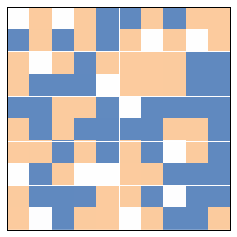

In [151]:
grid = Schelling(n=10)
viewer = SchellingViewer(grid)
viewer.draw(grid=True)
grid.segregation()

In [36]:
grid.array

array([[0, 2, 2, 1, 2, 1, 2, 1, 2, 1],
       [1, 1, 1, 2, 2, 1, 2, 2, 1, 0],
       [1, 1, 2, 2, 0, 2, 1, 1, 1, 2],
       [2, 0, 2, 1, 2, 1, 2, 2, 1, 1],
       [2, 1, 1, 0, 1, 1, 2, 1, 2, 1],
       [2, 2, 1, 1, 0, 1, 2, 2, 2, 1],
       [2, 2, 1, 2, 2, 1, 2, 2, 2, 2],
       [1, 1, 2, 1, 2, 1, 2, 2, 1, 2],
       [2, 2, 1, 1, 1, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 2, 1, 2, 1, 2]], dtype=int8)

In [37]:
arr = grid.array

In [38]:
arr[0:5]

array([[0, 2, 2, 1, 2, 1, 2, 1, 2, 1],
       [1, 1, 1, 2, 2, 1, 2, 2, 1, 0],
       [1, 1, 2, 2, 0, 2, 1, 1, 1, 2],
       [2, 0, 2, 1, 2, 1, 2, 2, 1, 1],
       [2, 1, 1, 0, 1, 1, 2, 1, 2, 1]], dtype=int8)

In [39]:
arr[0:5]

array([[0, 2, 2, 1, 2, 1, 2, 1, 2, 1],
       [1, 1, 1, 2, 2, 1, 2, 2, 1, 0],
       [1, 1, 2, 2, 0, 2, 1, 1, 1, 2],
       [2, 0, 2, 1, 2, 1, 2, 2, 1, 1],
       [2, 1, 1, 0, 1, 1, 2, 1, 2, 1]], dtype=int8)

In [40]:
dists = [arr[2*i:2*(i+1),5*j:5*(j+1)] for i in range(5) for j in range(2)]

In [11]:
arr[:5,0:5]

array([[1, 1, 2, 1, 2],
       [2, 1, 2, 2, 2],
       [1, 1, 1, 2, 1],
       [2, 1, 1, 1, 2],
       [2, 2, 1, 1, 2]], dtype=int8)

In [12]:
dists[0]

array([[1, 1, 2, 1, 2],
       [2, 1, 2, 2, 2]], dtype=int8)

In [13]:
dists[1]

array([[1, 2, 1, 2, 2],
       [2, 1, 1, 0, 2]], dtype=int8)

In [14]:
dists[2]

array([[1, 1, 1, 2, 1],
       [2, 1, 1, 1, 2]], dtype=int8)

In [15]:
d0 = dists[0]

In [16]:
d0f = d0.flatten()

In [17]:
l = list(d0f)

In [18]:
l

[1, 1, 2, 1, 2, 2, 1, 2, 2, 2]

In [19]:
l.count(2)

6

In [152]:
class Districts(Schelling):
    
    def __init__(self, n, m=None, p=0.5, rows=None, cols=None, empty_prob=0.1, red_prob=0.45):
        self.p = p
        self.n = n
        self.m = n if m is None else m
        self.rows = rows if rows is not None else 2
        self.cols = cols if cols is not None else 2
        self.schelling_grid = Schelling(n,m=m,p=p, empty_prob=empty_prob, red_prob=red_prob)
        self.array = self.schelling_grid.array
        self.row_mult = self.n//self.rows
        self.col_mult = self.m//self.cols
        try:
            assert(self.row_mult*self.rows==self.n)
            assert(self.col_mult*self.cols==self.m)
        except AssertionError:
            raise Exception(("The number of rows and number of columns must"
                             " divide the size of the grid."))
        self.districts = self.make_districts()
        
    def make_districts(self, array=None):
        if array is None:
            array = self.array
        return [array[self.row_mult*i: self.row_mult*(i+1),
                      self.col_mult*j: self.col_mult*(j+1)]
                for i in range(self.rows) for j in range(self.cols)]
    
    def votes(self, output=False):
        votes = dict()
        if output:
            print ("Vote totals\n-----------\n")
        for num, district in enumerate(self.districts):
            IS_RED = 1
            IS_BLUE = 2
            votes[num] = {'red': list(district.flatten()).count(IS_RED),
                          'blue': list(district.flatten()).count(IS_BLUE)}
            if output:
                print ("District {}::   Red vote: {},   Blue vote: {}".format(
                        num, votes[num]['red'], votes[num]['blue']))
        return votes
    
    def tally_votes(self, output=False):
        tallies = self.votes()
        if output:
            print ("Tallying votes\n--------------\n")
        for num, district in enumerate(self.districts):
            dist_tally = tallies[num]
            dist_tally.update(self.determine_winner(dist_tally))
        return tallies
            
    def determine_winner(self, vote_tally):
        res = dict()
        if vote_tally['red'] > vote_tally['blue']:
            res['winner'] = 'red'
            res['red_wasted'] = vote_tally['red'] - vote_tally['blue'] - 1
            res['blue_wasted'] = vote_tally['blue']
        elif vote_tally['blue'] > vote_tally['red']:
            res['winner'] = 'blue'
            res['blue_wasted'] = vote_tally['blue'] - vote_tally['red'] - 1
            res['red_wasted'] = vote_tally['red']
        else:
            res['winner'] = 'tie'
            res['red_wasted'] = 0
            res['blue_wasted'] = 0
        return res
    
    def net_wasted_votes_by_district(self):
        """
        We adopt the convention that 1 wasted vote means a wasted blue vote,
        while -1 wasted vote means a wasted red vote.
        """
        res = dict()
        tallies = self.tally_votes()
        for num, district in enumerate(self.districts):
            res[num] = tallies[num]['blue_wasted'] - tallies[num]['red_wasted']
        return res
    
    def net_wasted_votes(self):
        wasted_by_dist = self.net_wasted_votes_by_district()
        return sum(wasted_by_dist[num] for num in wasted_by_dist.keys())
    
    def efficiency_gap(self):
        return abs(self.net_wasted_votes()) / (self.n * self.m)
        
    
class District_Viewer(SchellingViewer):
    
    def __init__(self, districts):
        super().__init__(districts.schelling_grid)
        self.row_multiplier = districts.row_mult
        self.col_multiplier = districts.col_mult
        
    def draw_grid(self):
        """Draws the grid."""
        a = self.viewee.array
        n, m = a.shape
        lw = 2 if m < 10 else 1
        options = dict(color='white', linewidth=lw)

        rows = self.row_multiplier*np.arange(1, n)
        self.hlines = plt.hlines(rows, 0, m, **options)

        cols = self.col_multiplier*np.arange(1, m)
        self.vlines = plt.vlines(cols, 0, n, **options)

0.48894444017267641

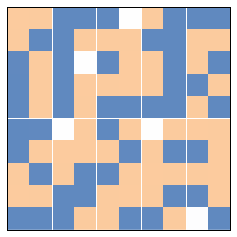

In [153]:
dgrid = Districts(10, cols=5, p=.2)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
dgrid.segregation()

In [154]:
dgrid.net_wasted_votes()

12

In [155]:
dgrid.step()

0.48894444017267641

In [156]:
dgrid.net_wasted_votes()

12

Beginning simulation.
After 0::   segregation: 0.5016512105329243   efficiency gap: 0.383
After 1::   segregation: 0.5744897341172209   efficiency gap: 0.16613333333333333
After 2::   segregation: 0.663514966653626   efficiency gap: 0.05865555555555556
After 3::   segregation: 0.7327100321254049   efficiency gap: 0.0213
After 4::   segregation: 0.7780127960032174   efficiency gap: 0.021966666666666666
After 5::   segregation: 0.8107205600326843   efficiency gap: 0.021377777777777777
After 6::   segregation: 0.8313115713169882   efficiency gap: 0.021666666666666667
After 7::   segregation: 0.8464624942432672   efficiency gap: 0.014966666666666666
After 8::   segregation: 0.8566399482456004   efficiency gap: 0.015322222222222221
After 9::   segregation: 0.8648838771659061   efficiency gap: 0.051644444444444444
After 10::   segregation: 0.8706854446161246   efficiency gap: 0.05188888888888889
After 11::   segregation: 0.8749663216958591   efficiency gap: 0.05168888888888889
After 12::   s

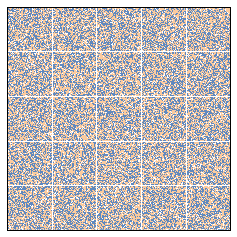

In [181]:
dgrid = Districts(300, cols=5, rows=5, p=.5, red_prob=0.47)
viewer = District_Viewer(dgrid)
viewer.draw(grid=True)
print("Beginning simulation.")
for i in range(50):
    print("After {}::   segregation: {}   efficiency gap: {}"
          .format(i, dgrid.segregation(), dgrid.efficiency_gap()))
    dgrid.step()

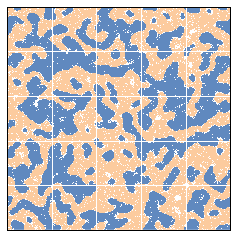

In [182]:
viewer.draw(grid=True)

In [130]:
np.array(3*[np.array(7*[np.array(1)])]) + np.array([np.array([1,1,1,0,1,1,1])])

array([[2, 2, 2, 1, 2, 2, 2],
       [2, 2, 2, 1, 2, 2, 2],
       [2, 2, 2, 1, 2, 2, 2]])

In [139]:
d = np.array(3*[np.ones(7)])

In [140]:
d

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [149]:
np.array([1]*24 + [0] + [1]*24).reshape((7,7))

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]])

In [145]:
np.reshape?